In [1]:
import sys
sys.path.append('..')

In [2]:
import arviz as az
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pymc3 as pm
import pandas as pd
from helpers import posterior_grid_approx, lfilter
from itertools import product

# 2. SMALL WORLDS AND LARGE WORLDS

## Practice

**2E1.** Which of the expressions below correspond to the statement: *the probability of rain on Monday*?
- (1) Pr(rain)
- **(2) Pr(rain|Monday)**
- (3) Pr(Monday|rain)
- (4) Pr(rain,Monday)/Pr(Monday)

**2E2.** Which of the following statements corresponds to the expression: Pr(Monday|rain)?
- (1) The probability of rain on Monday.
- (2) The probability of rain, given that it is Monday.
- **(3) The probability that it is Monday, given that it is raining.**
- (4) The probability that it is Monday and that it is raining.

**2E3.** Which of the expressions below correspond to the statement:*the probability that it is Monday,given that it is raining*?
- **(1) Pr(Monday|rain)**
- (2) Pr(rain|Monday)
- (3) Pr(rain|Monday)Pr(Monday)
- (4) Pr(rain|Monday)Pr(Monday)/Pr(rain)
- (5) Pr(Monday|rain)Pr(rain)/Pr(Monday)

**2E4.** The Bayesian statistician Bruno de Finetti (1906–1985) began his 1973 book on probability theory with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original,so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a de-vice for describing uncertainty from the perspective of an observer with limited knowledge; it has no objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What does it mean to say “the probability of water is 0.7”?

There is more than one interpretation to this statements. 
- It means that if you toss the globe 10 times, on average it will land on water 7 times
- Or, 70% of the planet is covered on water
- Or, with an infinite number of samples 70% of the time it will land on water

**2M1.** Recall the globe tossing model from the chapter. Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for *p*.

- (1) W, W, W
- (2) W, W, W, L
- (3) L, W, W, L, W, W, W

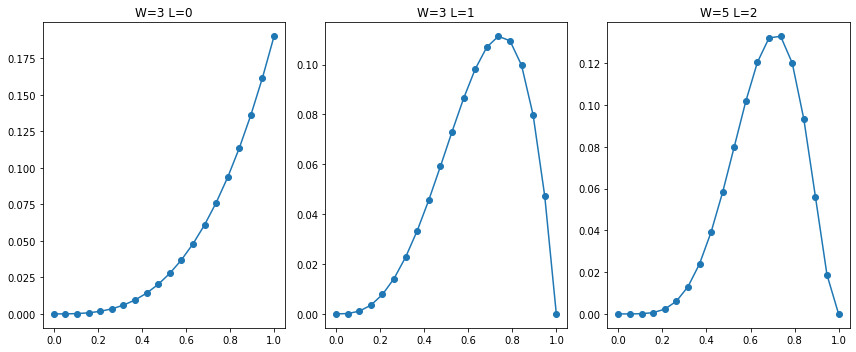

In [3]:
observations = [
    (3, 0),
    (3, 1),
    (5, 2)
]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, (w, l) in enumerate(observations):
    pgrid, posterior = posterior_grid_approx(20, w, w+l, 'uniform')
    axes[i].plot(pgrid, posterior, '-o')
    axes[i].set_title(f"W={w} L={l}")

fig.tight_layout()

**2M2.** Now assume a prior for *p* that is equal to zero when *p* < 0.5 and is a positive constant when *p* ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.

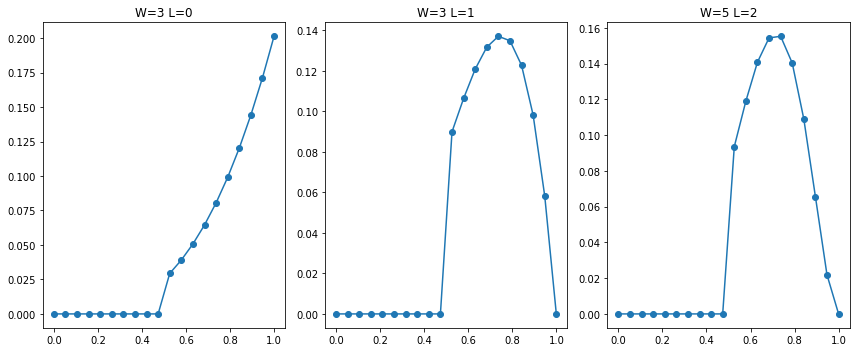

In [4]:
observations = [
    (3, 0),
    (3, 1),
    (5, 2)
]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, (w, l) in enumerate(observations):
    pgrid, posterior = posterior_grid_approx(20, w, w+l, 'truncated')
    axes[i].plot(pgrid, posterior, '-o')
    axes[i].set_title(f"W={w} L={l}")

fig.tight_layout()

**2M3.** Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes — you don’t know which — was tossed in the air and produced a *"land"* observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing *"land"* (Pr(Earth|land)), is 0.23

In [5]:
# Given
p_water_given_earth = 0.7
p_water_given_mars = 0.0

p_earth = 0.5

# Calculated
p_land_given_earth = 1 - p_water_given_earth
p_land_given_mars = 1 - p_water_given_mars

p_mars = 1 - p_earth

# Pr(Earth|Land)
p_land_given_earth * p_earth / (p_land_given_earth*p_earth + p_land_given_mars*p_mars)

0.23076923076923078

**2M4.** Suppose you have a deck with only three cards. Each card has two sides, and each side is either black or white. One card has two black sides. The second card has one black and one white side. The third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up, but you don’t know the color of the side facing down. Show that the probability that the other side is also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This means counting up the ways that each card could produce the observed data (a black side facing upon the table).

In [6]:
pos = [
    'BB',
    'BW',
    'WW',
    'BB',
    'WB',
    'WW',
]

In [7]:
first_B = lfilter(lambda x: x[0] == 'B', pos)

len(lfilter(lambda x: x[1] == 'B', first_B)) / len(first_B)

0.6666666666666666

In [8]:
p_bb = 1/3
p_black = (1/3 * 1) + (1/3 * 1/2) + (1/3 * 0)

p_black_given_bb = 1

# P(BB|B) = ( P(B|BB) * P(BB) ) / (P(B))
(p_black_given_bb * p_bb) / (p_black)

0.6666666666666666

In [9]:
# P(BB|B) = P(BB Inter B) / P(B)

(1/3) / p_black

0.6666666666666666

**2M5.** Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is drawn from the bag and a black side appears face up. Again calculate the probability that the otherside is black.

In [10]:
p_bb = 2/4
p_black = (1/4 * 1) + (1/4 * 1/2) + (1/4 * 0) + (1/4 * 1)

p_black_given_bb = 1

# P(BB|B) = ( P(B|BB) * P(BB) ) / (P(B))
(p_black_given_bb * p_bb) / (p_black)

0.8

**2M6.** Imagine that black ink is heavy, and so cards with black sides are heavier than cards with whitesides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that the probability the other side is black is now 0.5. Use the counting method, as before.

In [11]:
p_bb = 1/6
p_black = (1 * 1/6) + (1/2 * 2/6) + (0 * 3/6)

p_black_given_bb = 1

# P(BB|B) = ( P(B|BB) * P(BB) ) / (P(B))
(p_black_given_bb * p_bb) / (p_black)

0.5

**2M7.** Assume again the original card problem, with a single card showing a black side face up. Before looking at the other side, we draw another card from the bag and lay it face up on the table. The face that is shown on the new card is white. Show that the probability that the first card, the one showing a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat this like the sequence of globe tosses, counting all the ways to see each observation, for each possible first card.

In [12]:
cards = ['BB', 'BW', 'WB', 'WW']
possible_results = lfilter(lambda x: set(x[0]) != set(x[1]), product(cards, cards))

In [13]:
sims = []

for _ in range(10_000):
    sims.append(np.random.choice(['BB', 'BW', 'WW'], 2, replace=False))
    
sims = pd.DataFrame(np.vstack(sims), columns=['card1', 'card2'])
sims['card1'] = np.where(
    np.random.uniform(size=len(sims)) > .5,
    sims['card1'].str[1] + sims['card1'].str[0],
    sims['card1']
)
sims['card2'] = np.where(
    np.random.uniform(size=len(sims)) > .5,
    sims['card2'].str[1] + sims['card2'].str[0],
    sims['card2']
)

(sims
.loc[
    lambda x: (x['card1'].str[0] == 'B') & (x['card2'].str[0] == 'W'),
    'card1'
].str[1] == 'B').mean()

0.7446286065070595

In [14]:
# p_bb = 1/3
# p_black = 3/6
# p_white = 3/6

# p_black_given_bb = 1
# p_white_given_bb = 0

# p_bw_given_bb = p_black_given_bb * p_white_given_bb 
# # p_bw = 

# # P(BB|B,W) = (P(B,W|BB) * P(BB) / P(B,W))
# p_bb_given_bw = (p_bw_given_bb * p_bb) / p_bw

**2H1.** Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research.

Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?

In [15]:
# P(2t|1t) = P(A|1t) * P(T|A) + P(B|1t) * P(T|B)
p_twin_given_A = 0.1
p_twin_given_B = 0.2

p_A = 0.5
p_B = 0.5

p_twin = p_A * p_twin_given_A + p_B * p_twin_given_B

p_A_given_twin = (p_twin_given_A * p_A) / p_twin
p_B_given_twin = (p_twin_given_B * p_B) / p_twin

p_2twin_given_twin = p_A_given_twin * p_twin_given_A + p_B_given_twin * p_twin_given_B
p_2twin_given_twin

0.16666666666666666

**2H2.** Recall all the facts from the problem above. Now compute the probability that the panda we have is from species A, assuming we have observed only the first birth and that it was twins.

**2H3.** Continuing on from the previous problem, suppose the same panda mother has a second birth and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is species A.